# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [48]:
# Parameters
m = 1
A = 0.05#0.05#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [49]:
res=m;
N=2.0^m*500/4.0#1000.0#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=2.0^m*500.0#100.0*2^m*10
Tf=Nt*dt; #final time
print(Tf)

4.0

In [50]:
print(N)

250.0

In [51]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.004
dt =0.004
dx/dt =1.0


In [52]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [53]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [54]:
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
#T=range(0,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.004
the time step is 0.004


In [55]:
include("./ScalarField.jl");

# Initial data of m β Ψ and Ψ,x

In [56]:
using Dierckx

####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.3
sigma=0.3
"""initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)"""

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], initderpsi[4:L-3],  k=4);

In [57]:
y0=[0 0 0]
state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func)
state_array = ghost(state_array);

In [58]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, state_array[:,1:4], xaxis=\"x\",title=\"Initial Data\", labels=[\"m\" \"beta\" \"psi\" \"psi,x\"])"

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [59]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

In [60]:
time=0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [61]:
ginit=dt_scale(initX,state_array[:,1],state_array[:,2],dx)
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

1.0


 ## Time evolution

fixed grid

In [62]:
finaltime=1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,dir*"/res$res",run);
CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);

iteration 10 dt is 0.004, time of iteration is 0.04000000000000001
iteration 20 dt is 0.004, time of iteration is 0.08000000000000004
iteration 30 dt is 0.004, time of iteration is 0.12000000000000008
iteration 40 dt is 0.004, time of iteration is 0.16000000000000011
iteration 50 dt is 0.004, time of iteration is 0.20000000000000015
iteration 60 dt is 0.004, time of iteration is 0.24000000000000019
iteration 70 dt is 0.004, time of iteration is 0.2800000000000002
iteration 80 dt is 0.004, time of iteration is 0.32000000000000023
iteration 90 dt is 0.004, time of iteration is 0.36000000000000026
iteration 100 dt is 0.004, time of iteration is 0.4000000000000003
iteration 110 dt is 0.004, time of iteration is 0.44000000000000034
iteration 120 dt is 0.004, time of iteration is 0.48000000000000037
iteration 130 dt is 0.004, time of iteration is 0.5200000000000004
iteration 140 dt is 0.004, time of iteration is 0.5600000000000004
iteration 150 dt is 0.004, time of iteration is 0.60000000000

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
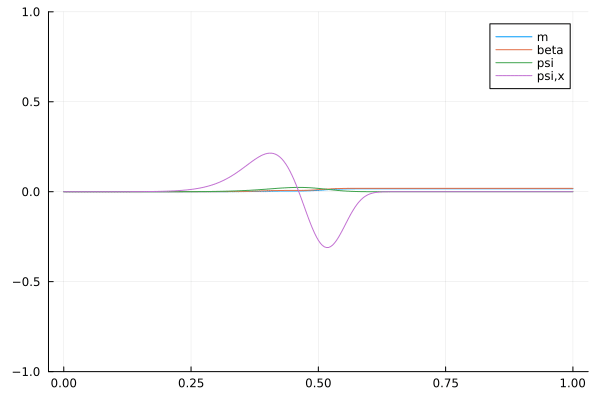

In [63]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 0:10:290#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], ylim=[-1, 1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
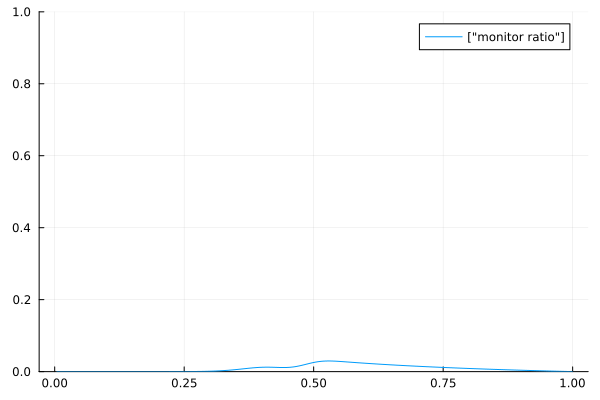

In [64]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:290#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

In [22]:
epsilon(dt,dx)

1.0671067235248162e8

In [647]:
iteration 5010 dt is 8.107532615016511e-12, time of iteration is 0.6658624521770952
iteration 5020 dt is 1.4603412731963235e-12, time of iteration is 0.665862452213098
Supercritical evolution! At time 0.6658624522174752
Gridpoint = 251 t = 0.6658624522174752 monitor ratio = 1.0015530116841327

LoadError: syntax: extra token "5010" after end of expression